# EggNOG column numbering scheme #
*For accessing results in this notebook, you must use 0-based indexing i.e. column number - 1*
1. query_name
2. seed eggNOG ortholog
3. seed ortholog evalue
4. seed ortholog score
5. Predicted taxonomic group
6. Predicted protein name
7. Gene Ontology terms 
8. EC number
9. KEGG_KO
10. KEGG_Pathway
11. KEGG_Module
12. KEGG_Reaction
13. KEGG_rclass
14. BRITE
15. KEGG_TC
16. CAZy 
17. BiGG Reaction
18. tax_scope: eggNOG taxonomic level used for annotation
19. eggNOG OGs 
20. bestOG (deprecated, use smallest from eggnog OGs)
21. COG Functional Category 
22. eggNOG free text description

# EggNOG Functional Categories #

#### INFORMATION STORAGE AND PROCESSING ####

 [J] Translation, ribosomal structure and biogenesis 
 
 [A] RNA processing and modification 
 
 [K] Transcription 
 
 [L] Replication, recombination and repair
 
 [B] Chromatin structure and dynamics 

#### CELLULAR PROCESSES AND SIGNALING ####

 [D] Cell cycle control, cell division, chromosome partitioning 
 
 [Y] Nuclear structure 
 
 [V] Defense mechanisms 
 
 [T] Signal transduction mechanisms 
 
 [M] Cell wall/membrane/envelope biogenesis
 
 [N] Cell motility 
 
 [Z] Cytoskeleton 
 
 [W] Extracellular structures
 
 [U] Intracellular trafficking, secretion, and vesicular transport 
 
 [O] Posttranslational modification, protein turnover, chaperones 

#### METABOLISM ####

 [C] Energy production and conversion
 
 [G] Carbohydrate transport and metabolism 
 
 [E] Amino acid transport and metabolism 
 
 [F] Nucleotide transport and metabolism 
 
 [H] Coenzyme transport and metabolism
 
 [I] Lipid transport and metabolism 
 
 [P] Inorganic ion transport and metabolism
 
 [Q] Secondary metabolites biosynthesis, transport and catabolism 

#### POORLY CHARACTERIZED ####

 [R] General function prediction only 
 
 [S] Function unknown 

In [1]:
eggNOG_categories = { "J": "Translation, ribosomal structure and biogenesis", "A": "RNA processing and modification",
                  "K": "Transcription", "L": "Replication, recombination and repair", "B": "Chromatin structure and dynamics", 
                  "D": "Cell cycle control, cell division, chromosome partitioning", "Y": "Nuclear structure", "V": "Defense mechanisms",
                  "T": "Signal transduction mechanisms","M": "Cell wall/membrane/envelope biogenesis","N": "Cell motility",
                  "Z": "Cytoskeleton", "W": "Extracellular structures","U": "Intracellular trafficking, secretion, and vesicular transport",
                  "O": "Posttranslational modification, protein turnover, chaperones", "C": "Energy production and conversion","G": "Carbohydrate transport and metabolism",
                  "E": "Amino acid transport and metabolism", "F": "Nucleotide transport and metabolism",
                  "H": "Coenzyme transport and metabolism","I": "Lipid transport and metabolism","P": "Inorganic ion transport and metabolism",
                  "Q": "Secondary metabolites biosynthesis, transport and catabolism", 
                  "R": "General function prediction only",
                  "S": "Function unknown"}

In [2]:
### Import Required Libraries ###
### Most of these are included in anaconda, others can be installed via pip or bioconda ###
import pandas as pd
import numpy as np
import collections as collect
import glob 
import os
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
#from bioservices import kegg if you want to download annotations yourself

Analysis performed by Jonathan Lombardino, Burton Lab, Department of Bacteriology, Madison, Wisconsin

email: jlombardino@wisc.edu 

For questions regarding data or installation of these packaged or If you use any of these functions, please remember to cite the associated EggNOG citations and this mansucript! 

# Functions for parsing eggNOG Results #

In [3]:
def parse_annotations(indir, subfolders = True):
    if subfolders == True:
        files = glob.glob(os.path.join(indir, "**/*.annotations"))
    else:
        files = glob.glob(os.path.join(indir, "*.annotations"))
    return files

In [4]:
def read_annotations(filein):
    """ 
    Function for reading a EggNOG-MapperV2 annotations file to a table format
    Input: path to annotations file
    Output: dataframe of annotations table
    """
    names = ["query_name", "seed_ortholog", "evalue", "score", "predicted_taxa", "predicted_name", 
             "GO", "EC", "KEGG_KO","KEGG_Pathway", "KEGG_Module","KEGG_Reaction", "KEGG_rclass", "BRITE",
             "KEGG_TC", "CAZy", "BiGG Reaction", "tax_scope", "eggNOG_OGs", "best_OG", "COG_Category", "description"]
    df = pd.read_csv(filein, comment="#", sep = "\t", names = names)
    return df

In [5]:
def get_cogs(df, normalization):
    """
    Function for reading an annotations file and extracting the functional 
    annotations. 
    Input: 
        df: Dataframe of eggNOG-V2 annotations file
        normalization: {"all", "named"}
    Output: Dictionary structure of the counts of each eggNOG function
    """
    ### make an empty list ###
    cog_strings = []
    length_df = len(df)
    ### Count the total number of annotations before dropping NaN for one form of normalization ###
    cog_col = df.iloc[:,20].dropna()
    #print(cog_col)
    for row in cog_col:
        ### Take all cog categories from a proteins entry ###
        #print(row)
        row_items = list(row)
        #print(row_items)
        for item in row_items:
            cog_strings.append(item) ## add to list of strings ##
    
    output = collect.Counter(cog_strings) ## count the number of each type
    
    alphabet=["A","B","C","D","E","F","G","H","I",
              "J","K","L","M","N","O","P","Q","R","S",
              "T","U","V","W","Y","Z"]
    
    for letter in alphabet:
        if letter not in output.keys(): ## check to see if letter is in the counts
            output[letter] = 0 ## if not add to the dictionary and keep count as zero. 
    
    sorted_output = dict()
    
    if normalization == "all":
        total = length_df
    elif normalization == "named":
        total = sum(output.values())
    else: 
        raise Exception("normalization must be 'named' or 'all'")
    for letter in alphabet:
        sorted_output[letter] = round((output[letter] / total) * 100, 3)
    
    return sorted_output 
    
        

In [6]:
def collect_eggnog_annotations(files, names, normalization):
    """
    Parse through each file and genome name and collect COG functional categories
    """
    #os.cd(dir_path) ## change user to eggnog data folder from current path
    genomes = dict()
    for f,n in zip(files, names):
        genomes[n] = get_cogs(read_annotations(f), normalization)
    return genomes


In [7]:
def pileup(files,names, column="eggNOG", output_type="default", skip_multi=False):
    #https://stackoverflow.com/questions/51538480/dictionary-to-dataframe-presence-absence
    """
    Parse through directory folders and retrieve annotation files
    Args:
        files: list of files to parse
        names: genome names to assign.
        column: column 0-based to pileup on
    INFO:
    KO: 0-based index is 8,
    EggNOG_Names: 0-based index is 5, Note use description dictionary function for this
    KEGG Reaction: 0-based is 11
    returns a dataframe compatible with upsetR or upsetPython.
    """
    genomes = dict()
    ### Scrape through each annotation file ###
    for f,n in zip(files,names):
        #genome_name = folder.split("/")[-2]
        genome_name = n
        if column == "eggNOG":
            df = read_annotations(f)
            df["Key"] = df.seed_ortholog.astype(str) + "//" + df.predicted_taxa.astype(str)+ "//" + df.predicted_name.astype(str) +\
            "//"+df.description.astype(str)+"//"+df.COG_Category.astype(str)
            accessions = df.Key
        else:
            accessions = []
            entries = list(read_annotations(f).iloc[:,column].dropna()) #get specified column
            ### Parse through each row of column ###
            for entry in entries:
                items = str(entry).split(",")
                ### Breakup entries that are lists of more than one accession, or skip them ###
                if (len(items) > 1) and (skip_multi == False):
                    for i in items:
                        accessions.append(i)
                elif (len(items) > 1) and (skip_multi == True):
                    continue
                else:
                    accessions.append(entry)
        genomes[genome_name] = accessions
        
    if output_type == "default": # output lists of accessions per genome
        output = pd.DataFrame.from_dict(genomes, orient="index").fillna("NaN")
        output = output.transpose()
        
    elif output_type == "count": # output counts of each accession per genome
        output = pd.DataFrame({k:collect.Counter(v) for k, v in genomes.items()}).fillna(0).astype(int)
    
    elif output_type == "indicator": # output binary table of each accession per genome (1 present, 0 absent)
        mlb = MultiLabelBinarizer()
        output = pd.DataFrame(mlb.fit_transform(genomes.values()),columns=mlb.classes_, index=genomes.keys()).transpose()
    else:
        raise Exception("**Error, must be one of the following {default, count, indicator}")
    return output 

In [21]:
def find_unique_genes(df, use_endophytes = True):
    space_pauci = ["Paucimobilis FKI-L5-BR-P1", "Paucimobilis LCT-SP1"]
    type_pauci = ["Paucimobilis NCTC11030"]
    space_sang = ["Sanguinis IIF7SW-B3A", "Sanguinis IIF7SW-B5", "Sanguinis ISS-IIF7SWP"]
    type_sang = ["Sanguinis NBRC 13937"]
    endophytes = ["Sphingomonas LK11"]
    space_genomes = space_sang + space_pauci
    type_genomes = type_sang + type_pauci
    all_genomes = space_pauci + type_pauci + space_sang + type_sang 
    present_all, unique_space_pauci, unique_space_sang, unique_all_space = [], [], [], []
    unique_endophytes = []
    for row in df.iterrows():
        results = row[1]
        ### Evaluate paucimobilis ###
        if any( [results[i] != 0 for i in space_pauci] ) and all( [results[j] == 0 for j in type_pauci] ):
            ### Here at least one space paucimobilis strain contained a protein not present in type strain ###
            unique_space_pauci.append(True)
        else:
            unique_space_pauci.append(False)

        ### Evaluate sanguinis ###
        if any( [results[i] != 0 for i in space_sang] ) and all( [results[j] == 0 for j in type_sang] ):
            unique_space_sang.append(True)
        else:
            unique_space_sang.append(False)
        ### Evaluate if each protein is present in each genome ###
        if all([results[i] != 0 for i in all_genomes]):
            present_all.append(True)
        else:
            present_all.append(False)
        
        ### Find proteins that are in all of the space genomes but not in the type strains ###
        if all( [results[i] != 0 for i in space_genomes]) and all([ results[j] == 0 for j in type_genomes ]):
            unique_all_space.append(True)
        else:
            unique_all_space.append(False)
        if use_endophytes == True:
            if all ([results[i] == 0 for i in all_genomes]) and all( [results[j] != 0 for j in endophytes] ):
                unique_endophytes.append(True)
            else:
                unique_endophytes.append(False)
                
    
    ### Add new Columns to dataframe ###
    df["Present_All"] = present_all
    df["Unique_Space_Paucimobilis"] = unique_space_pauci
    df["Unique_Space_Sanguinis"] = unique_space_sang
    df["Unique_Space_All"] = unique_all_space
                    
    if use_endophytes == True:
        df["Unique_LK11"] = unique_endophytes
    return df


# EggNOG Functional Categories Hierarchical Clustering #

In [9]:
keep_lk11 = True
infiles = parse_annotations(".") #folder of annotations are present in the current directory 
genomes_names = [x.split("/")[-2].replace("_", " ") for x in infiles]
if keep_lk11 == False:
    infiles.remove("LK11")
    genomes_names.remove("LK11")
print(genomes_names)

['Paucimobilis FKI-L5-BR-P1', 'Paucimobilis LCT-SP1', 'Paucimobilis NCTC11030', 'Sanguinis IIF7SW-B3A', 'Sanguinis IIF7SW-B5', 'Sanguinis ISS-IIF7SWP', 'Sanguinis NBRC 13937', 'Sphingomonas LK11']


In [10]:
### Collect the COG functional Categories ###
genomes = collect_eggnog_annotations(infiles,genomes_names, "all")
genome_df = pd.DataFrame(genomes)
categories_df = pd.DataFrame.from_records(eggNOG_categories, index=["Description"]).T.assign(Category = lambda x: x.index + ": " + x.Description)
genome_df = genome_df.merge(categories_df, how="left", left_index=True, right_index=True).set_index("Category").drop("Description", axis=1)

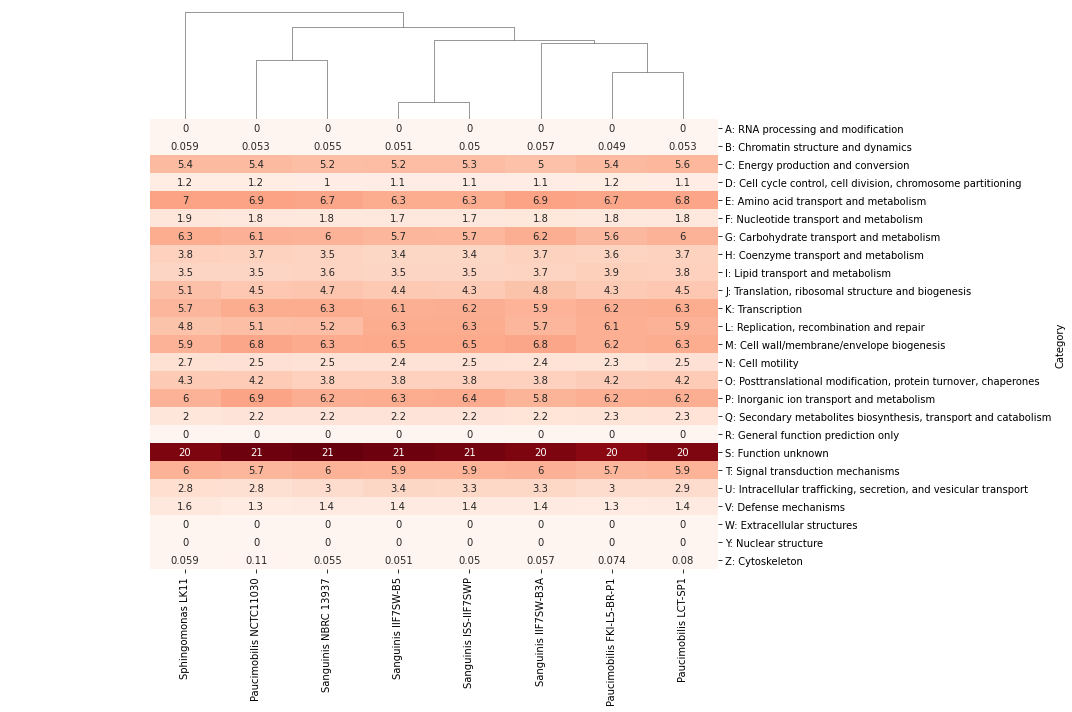

In [30]:
### Create a hierarchical cluster of results using average euclidean (or others) ###
cluster = sns.clustermap(genome_df, method="average", metric="euclidean", figsize= (15,10), row_cluster=False, annot = True,cbar_pos = None,cmap="Reds")
plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cluster.savefig("EggNOG_Functions_average_euclidean.svg")
cluster.savefig("EggNOG_Functions_average_euclidean.png")

# Parse Accession-Based columns for Intersection analysis #

### Retrieve KEGG Accessions and store in a dataframe for easier access, hashed because it is quite slow 

In [12]:
#s = kegg.KEGG() ## Access Bioservices (if you'd like, though webscraping is time intensive on python)

In [19]:
def make_kegg_table(inputdb, output_name, kegg_var, organism=None, replacement = None):
    """
    Scrape accession, definition pairings for KEGG bioservices module's list 
    """
    res = kegg_var.list(inputdb, organism=organism) #retrieve items
    item_list = res.split("\n") #split each accession
    rows = [i.split("\t") for i in item_list] #split ids and descriptions into separate columns
    df = pd.DataFrame(rows, columns = ["ID", "Description"]) #make a dataframe
    if replacement is not None:
        df.replace(str(replacement),"", regex=True, inplace=True)
    df.to_csv(output_name, index=False) #save it to a csv
    
#make_kegg_table("ko", "KO_Table.csv", s) ##Get KO accession descriptions - DONE
#make_kegg_table("path", "Pathway_Table.csv", s, replacement="path:") ## uses map accession only?
#make_kegg_table("module", "Modules_Table.csv", s, replacement="md:") - DONE
#make_kegg_table("reaction", "Reaction_Table.csv", s, organism=None, replacement="rn:") - DONE

# Parsing Annotations For Intersection Analysis of EggNOG Results #

In [22]:
def read_descriptions(path):
    """
    Read preloaded tables from KEGG bioservices
    """
    return pd.read_csv(path, sep=",", header=0, names=["ID", "Descriptions"])
#names = ["KO_Counts.csv","Module_Counts.csv","Reactions_Counts.csv"]
description_paths = ["KO_Table.csv", "Modules_Table.csv", "Reaction_Table.csv"]
descriptions_dfs = map(read_descriptions, description_paths)
cols = [8,10,11]
output_dfs = []
for i,j in zip(cols,descriptions_dfs):
    df = pileup(infiles,genomes_names, column=i, output_type="count")
    j.index = j.ID
    new_df = df.merge(j, left_index=True,right_index=True).reset_index(drop=True)
    column_names = ["ID","Descriptions"] + genomes_names
    new_df = new_df[column_names]
    output_dfs.append(find_unique_genes(new_df)) 

In [23]:
### Here use only named eggNOG predicted proteins for intersection analysis ###
output_dfs.append(find_unique_genes(pileup(infiles, genomes_names,column=5,output_type="count")))

### However there are unnamed proteins that comprise a majority of the eggNOG output that is likely interesting ###
df = pileup(infiles,genomes_names,column="eggNOG", output_type="count") ## Grab the eggNOG proteins names 
df["Key"] = df.index
df[['Seed', 'Taxa','Name', "Description", "Category"]] = df.Key.str.split("//", expand=True)
df = df.drop("Key", axis=1)
df = df.reset_index(drop=True)
df["Key"] = df.Taxa + ":" + df.Name + ":" + df.Description + ":" + df.Category
new_columns = ["Key", "Seed","Category","Taxa","Name","Description"] + genomes_names
eggNOG = df[new_columns]

In [24]:
eggNOG

,Key,Seed,Category,Taxa,Name,Description,Paucimobilis FKI-L5-BR-P1,Paucimobilis LCT-SP1,Paucimobilis NCTC11030,Sanguinis IIF7SW-B3A,Sanguinis IIF7SW-B5,Sanguinis ISS-IIF7SWP,Sanguinis NBRC 13937,Sphingomonas LK11
0,Sphingomonadales:nan:Histidine kinase-like ATP...,1007104.SUS17_3789,T,Sphingomonadales,nan,Histidine kinase-like ATPases,2,1,1,0,0,0,0,0
1,Sphingomonadales:nan:Transcriptional regulator...,1007104.SUS17_3788,T,Sphingomonadales,nan,"Transcriptional regulatory protein, C terminal",1,1,1,0,0,0,0,0
2,Sphingomonadales:nan:nan:nan,1219049.SP5_104_00060,nan,Sphingomonadales,nan,nan,1,1,1,1,1,1,1,0
3,Sphingomonadales:nan:Enoyl-(Acyl carrier prote...,1007104.SUS17_2447,IQ,Sphingomonadales,nan,Enoyl-(Acyl carrier protein) reductase,1,1,1,0,0,0,0,0
4,Sphingomonadales:cybB:Prokaryotic cytochrome b...,1007104.SUS17_2446,C,Sphingomonadales,cybB,Prokaryotic cytochrome b561,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,Sphingomonadales:eriC:Voltage gated chloride c...,1549858.MC45_18290,P,Sphingomonadales,eriC,Voltage gated chloride channel,0,0,0,0,0,0,0,1
8723,Sphingomonadales:crcB:Important for reducing f...,392499.Swit_2801,U,Sphingomonadales,crcB,Important for reducing fluoride concentration ...,0,0,0,0,0,0,0,1
8724,Sphingomonadales:ino1:Inositol-3-phosphate syn...,1090320.KB900605_gene2077,I,Sphingomonadales,ino1,Inositol-3-phosphate synthase,0,0,0,0,0,0,0,1
8725,Sphingomonadales:tnpS:Phage integrase family:L,13690.CP98_04085,L,Sphingomonadales,tnpS,Phage integrase family,0,0,0,0,0,0,0,1


In [26]:
### Since multiple seed orthologs map to a taxa:predicted name combo with slightly different descriptions, aggregate results ###
if keep_lk11 == False:
    eggNOG = eggNOG.groupby("Key").agg({"Seed": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Taxa": "first",
                                        "Name": "first",
                                        "Category": lambda x: "".join(str(i) for i in np.unique(x)), 
                                        "Description": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Paucimobilis FKI-L5-BR-P1": lambda x: sum(x), 
                                        "Paucimobilis LCT-SP1": lambda x: sum(x),
                                        "Paucimobilis NCTC11030": lambda x: sum(x), 
                                        "Sanguinis IIF7SW-B3A": lambda x: sum(x),
                                        "Sanguinis IIF7SW-B5": lambda x: sum(x), 
                                        "Sanguinis ISS-IIF7SWP": lambda x: sum(x),
                                        "Sanguinis NBRC 13937": lambda x: sum(x)})
if keep_lk11 == True:
    eggNOG = eggNOG.groupby("Key").agg({"Seed": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Taxa": "first",
                                        "Name": "first",
                                        "Category": lambda x: "".join(str(i) for i in np.unique(x)), 
                                        "Description": lambda x: " // ".join(str(i) for i in np.unique(x)),
                                        "Paucimobilis FKI-L5-BR-P1": lambda x: sum(x), 
                                        "Paucimobilis LCT-SP1": lambda x: sum(x),
                                        "Paucimobilis NCTC11030": lambda x: sum(x), 
                                        "Sanguinis IIF7SW-B3A": lambda x: sum(x),
                                        "Sanguinis IIF7SW-B5": lambda x: sum(x), 
                                        "Sanguinis ISS-IIF7SWP": lambda x: sum(x),
                                        "Sanguinis NBRC 13937": lambda x: sum(x),
                                        "Sphingomonas LK11": lambda x: sum(x)})

In [27]:
output_eggNOG = find_unique_genes(eggNOG)
output_dfs.append(output_eggNOG)
output_eggNOG

,Seed,Taxa,Name,Category,Description,Paucimobilis FKI-L5-BR-P1,Paucimobilis LCT-SP1,Paucimobilis NCTC11030,Sanguinis IIF7SW-B3A,Sanguinis IIF7SW-B5,Sanguinis ISS-IIF7SWP,Sanguinis NBRC 13937,Sphingomonas LK11,Present_All,Unique_Space_Paucimobilis,Unique_Space_Sanguinis,Unique_Space_All,Unique_LK11
Key,,,,,,,,,,,,,,,,,,
Acidithiobacillales:yoqW:SOS response associated peptidase (SRAP):S,1123368.AUIS01000006_gene572,Acidithiobacillales,yoqW,S,SOS response associated peptidase (SRAP),0,0,0,0,0,0,1,0,False,False,False,False,False
Acidobacteria:nan:RHS Repeat:M,682795.AciX8_3261,Acidobacteria,nan,M,RHS Repeat,0,0,3,1,1,1,1,0,False,False,False,False,False
Acidobacteriia:glf:UDP-galactopyranose mutase:M,240015.ACP_0182,Acidobacteriia,glf,M,UDP-galactopyranose mutase,0,1,0,0,0,0,0,0,False,True,False,False,False
Acidobacteriia:rfbX:Polysaccharide biosynthesis protein:S,240015.ACP_0043,Acidobacteriia,rfbX,S,Polysaccharide biosynthesis protein,0,1,0,0,0,0,0,0,False,True,False,False,False
Acidobacteriia:yagU:Protein of unknown function (DUF1440):S,278963.ATWD01000001_gene4411,Acidobacteriia,yagU,S,Protein of unknown function (DUF1440),1,0,0,0,0,0,0,0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unclassified Burkholderiales:cbpA:heat shock protein DnaJ:O,987059.RBXJA2T_02467,unclassified Burkholderiales,cbpA,O,heat shock protein DnaJ,0,0,0,0,0,0,0,1,False,False,False,False,True
unclassified Burkholderiales:eno:Catalyzes the reversible conversion of 2- phosphoglycerate into phosphoenolpyruvate. It is essential for the degradation of carbohydrates via glycolysis:G,1158292.JPOE01000002_gene1514,unclassified Burkholderiales,eno,G,Catalyzes the reversible conversion of 2- phos...,0,0,0,0,0,0,1,1,False,False,False,False,False
unclassified Burkholderiales:nan:Glycosyl transferases group 1:M,983917.RGE_10770,unclassified Burkholderiales,nan,M,Glycosyl transferases group 1,0,0,0,1,1,1,0,0,False,False,True,False,False


In [28]:
print("The output dataframe will consist of this many sheets:" +  " " + str(len(output_dfs)) )
sheet_names = ["KO", "Modules", "Reactions","EggNOG_Named_Proteins","EggNOG_All_Seed_Orthologs"]
with pd.ExcelWriter('Supplementary_Table1.xlsx') as writer:  
    for i,j in zip(output_dfs, sheet_names):
        i.to_excel(writer, sheet_name=j)

The output dataframe will consist of this many sheets: 5


In [29]:
eggNOG_upsetR = pileup(infiles,genomes_names, column=5)
eggNOG_upsetR
#eggNOG_upsetR.to_csv("eggNOG_Named_Proteins.csv", index=False)

,Paucimobilis FKI-L5-BR-P1,Paucimobilis LCT-SP1,Paucimobilis NCTC11030,Sanguinis IIF7SW-B3A,Sanguinis IIF7SW-B5,Sanguinis ISS-IIF7SWP,Sanguinis NBRC 13937,Sphingomonas LK11
0,cybB,MA20_41710,gumB,nasA,virB11,pspB,mazG,maeB
1,ysmA,yjdF,ywqD,nirD,virD4,mtgA,hflX,mutS
2,nitA,uup,ywqD,nirB,lin,ybaB,hfq,mscL
3,maiA,yhbW,rhsB,nasA,uvrB,dnaX,ntrX,lemA
4,iorB,phnX,traI,nrt,ndh,fdxB,ntrY,nudF
...,...,...,...,...,...,...,...,...
2065,NaN,NaN,NaN,NaN,NaN,yvfI,NaN,NaN
2066,NaN,NaN,NaN,NaN,NaN,yvfH,NaN,NaN
2067,NaN,NaN,NaN,NaN,NaN,rpoN,NaN,NaN
2068,NaN,NaN,NaN,NaN,NaN,alpA,NaN,NaN


In [ ]:
### Reports species specific differences rather than shared orthology
#seed_orthologs_upsetR = pileup(infiles,genomes,column=1)
#seed_orthologs_upsetR.to_csv("eggNOG_Seed_Orthologs.csv", index=False)


In [ ]:
## Pattern similar to that reported using predicted eggNOG proteins ##
#eggNOG_upset_ko = pileup(infiles,genomes_names, column=8)
#eggNOG_upset_ko.to_csv("eggNOG_upset_ko", index=False)